In [1]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import transformers
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()
pd.set_option('display.max_columns',None)
print(f'TF version: {tf.__version__}')
print(f'transformers version: {transformers.__version__}')

TF version: 2.6.4
transformers version: 4.20.1


In [2]:
'''
VERSION: 5
DESC: Deberta v3 base with tensorflow, default CFG
'''
DEBERTA_MODEL="../input/debertav3base"
DATA_PATH="../input/feedback-prize-english-language-learning/"

In [3]:
#Reading data
df_modeling = pd.read_csv(DATA_PATH+"train.csv")
df_sub = pd.read_csv(DATA_PATH+"test.csv")
df_train, df_test = train_test_split(df_modeling,test_size=0.20, random_state=123)

In [4]:
#Useful functions
def inputfromDF(df):
    X = df['full_text']
    Y1 = df['cohesion']
    Y2 = df['syntax']
    Y3 = df['vocabulary']
    Y4 = df['phraseology']
    Y5 = df['grammar']
    Y6 = df['conventions']
    return X, Y1, Y2, Y3, Y4, Y5, Y6

#Roundoff prediction score to nearest multiple of 0.5
def roundoffScore(n):
    x1=math.floor(n)
    if n>x1+0.75:
        return x1+1.0
    elif n>x1+0.25:
        return x1+0.5
    else:
        return x1

#Mean of Root Mean Squared Error of multiple targets
def MCRMSE(y_test, y_pred):
    mse_list=[]
    target_names = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
    for i in range(y_test.shape[1]):
        mse_list.append(mean_squared_error(y_test[:,i], y_pred[:,i]))
        print("MSE for {} : {:.4f}".format(target_names[i], mean_squared_error(y_test[:,i], y_pred[:,i])))
    return sum(mse_list)/y_test.shape[1]

#Data encoder to tokenize input text for input of deberta
tokenizer = transformers.AutoTokenizer.from_pretrained(DEBERTA_MODEL)
def data_encoder(df,column,tokenizer=tokenizer,MAX_LENGTH=64, return_labels=True):
    text_array=df[column].tolist()
    input_ids, attention_masks = [], []
    for i in text_array:
        token=tokenizer(i,add_special_tokens=True, max_length=MAX_LENGTH, return_attention_mask=True, return_tensors="np", truncation=True, padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_masks.append(token['attention_mask'][0])
    if return_labels:
        labels = np.array(df[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]])
        return np.array(input_ids, dtype="int32"), np.array(attention_masks, dtype="int32"), labels
    else:
        return np.array(input_ids, dtype="int32"), np.array(attention_masks, dtype="int32")

#Training dataset generator
def get_train_dataset(ids, mask, y):
    x = tf.data.Dataset.from_tensor_slices({"input_ids": tf.constant(ids, dtype="int32"),"attention_mask": tf.constant(mask, dtype="int32")})
    y = tf.data.Dataset.from_tensor_slices((
        tf.constant(y[:, 0], dtype="float32"),
        tf.constant(y[:, 1], dtype='float32'),
        tf.constant(y[:, 2], dtype='float32'),
        tf.constant(y[:, 3], dtype='float32'),
        tf.constant(y[:, 4], dtype='float32'),
        tf.constant(y[:, 5], dtype='float32'),
    ))
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    data = tf.data.Dataset.zip((x, y))
    data = data.with_options(options)
    data = data.repeat()#To repeat infinitely
    data = data.shuffle(BUFFER_SIZE)#To shuffle entire dataset
    data = data.batch(BATCH_SIZE)#Combine elements into batches
    data = data.prefetch(AUTO)#Number of batch to be ready by CPU when the GPU is processing
    return data

#Validation dataset generator
def get_val_dataset(ids, mask, y):
    x = tf.data.Dataset.from_tensor_slices({
        "input_ids": tf.constant(ids, dtype="int32"),
        "attention_mask": tf.constant(mask, dtype="int32")
    })
    y = tf.data.Dataset.from_tensor_slices((
        tf.constant(y[:, 0], dtype="float32"),
        tf.constant(y[:, 1], dtype='float32'),
        tf.constant(y[:, 2], dtype='float32'),
        tf.constant(y[:, 3], dtype='float32'),
        tf.constant(y[:, 4], dtype='float32'),
        tf.constant(y[:, 5], dtype='float32'),
    ))
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    data = tf.data.Dataset.zip((x, y))
    data = data.with_options(options)
    data = data.repeat()
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(AUTO)
    return data

#Prediction dataset generator
def get_pred_dataset(ids, mask):
    x = tf.data.Dataset.from_tensor_slices({
        "input_ids": tf.constant(ids, dtype="int32"),
        "attention_mask": tf.constant(mask, dtype="int32")
    })
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    data = x
    data = data.with_options(options)
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(AUTO)
    return data

#Meanpool layer required in deberta
class MeanPool(tf.keras.layers.Layer):
    def call(self, x, mask=None):
        broad_mask = tf.cast(tf.expand_dims(mask, -1), "float32")
        x = tf.math.reduce_sum( x * broad_mask, axis=1)
        x = x / tf.math.maximum(tf.reduce_sum(broad_mask, axis=1), tf.constant([1e-9]))
        return x

/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [5]:
#Model building using deberta and Keras Functional API
def build_model(trainable=True):
    input1 = tf.keras.Input(shape=(MAX_LENGTH,), dtype="int32", name="input_ids")
    input2 = tf.keras.Input(shape=(MAX_LENGTH,), dtype="int32", name="attention_mask")
    base_model = transformers.TFAutoModel.from_pretrained(DEBERTA_MODEL)
    base_model.trainable = trainable
    base_outputs = base_model.deberta({"input_ids": input1,"attention_mask": input2})
    last_hidden_state = base_outputs[0]
    x = MeanPool()(last_hidden_state, mask=input2)
    
    x1 = tf.keras.layers.Dense(units=32, activation='relu',kernel_initializer='he_normal')(x)
    x1 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x1)
    output1 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x1)
    
    x2 = tf.keras.layers.Dense(units=32, activation='relu',kernel_initializer='he_normal')(x)
    x2 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x2)
    output2 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x2)
    
    x3 = tf.keras.layers.Dense(units=32, activation='relu',kernel_initializer='he_normal')(x)
    x3 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x3)
    output3 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x3)
    
    x4 = tf.keras.layers.Dense(units=32, activation='relu',kernel_initializer='he_normal')(x)
    x4 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x4)
    output4 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x4)
    
    x5 = tf.keras.layers.Dense(units=32, activation='relu',kernel_initializer='he_normal')(x)
    x5 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x5)
    output5 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x5)
    
    x6 = tf.keras.layers.Dense(units=32, activation='relu',kernel_initializer='he_normal')(x)
    x6 = tf.keras.layers.Dense(units='1', activation='sigmoid')(x6)
    output6 = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x6)
    
    model = tf.keras.Model(inputs={"input_ids": input1,"attention_mask": input2}, outputs= [output1,output2,output3,output4,output5,output6])
    return model

In [6]:
MAX_LENGTH=512
BATCH_SIZE = 8
BUFFER_SIZE = df_train.shape[0]
AUTO = 1
steps_per_epoch = df_train.shape[0]//BATCH_SIZE
validation_steps = df_test.shape[0]//BATCH_SIZE

In [7]:
input_train=data_encoder(df_train,'full_text',tokenizer=tokenizer,MAX_LENGTH=MAX_LENGTH,return_labels=True)
input_test=data_encoder(df_test,'full_text',tokenizer=tokenizer,MAX_LENGTH=MAX_LENGTH,return_labels=True)
input_sub=data_encoder(df_sub,'full_text',tokenizer=tokenizer,MAX_LENGTH=MAX_LENGTH,return_labels=False)

In [8]:
train_dataset = get_train_dataset(input_train[0], input_train[1], input_train[2])
test_dataset = get_val_dataset(input_test[0], input_test[1], input_test[2])
test_dataset_wo_label = get_pred_dataset(input_test[0], input_test[1])
sub_dataset = get_pred_dataset(input_sub[0], input_sub[1])

2022-11-01 18:58:38.641394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 18:58:38.735774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 18:58:38.736495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 18:58:38.739029: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
tf.keras.backend.clear_session()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001)
reduceLR=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=3,min_delta=0.0000001,min_lr=0.00000001,mode="auto")
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0.0000001,patience=5,restore_best_weights=True, mode='min')

In [13]:
#Initiate model object and its architecture
model=build_model()
model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mean_squared_error'])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


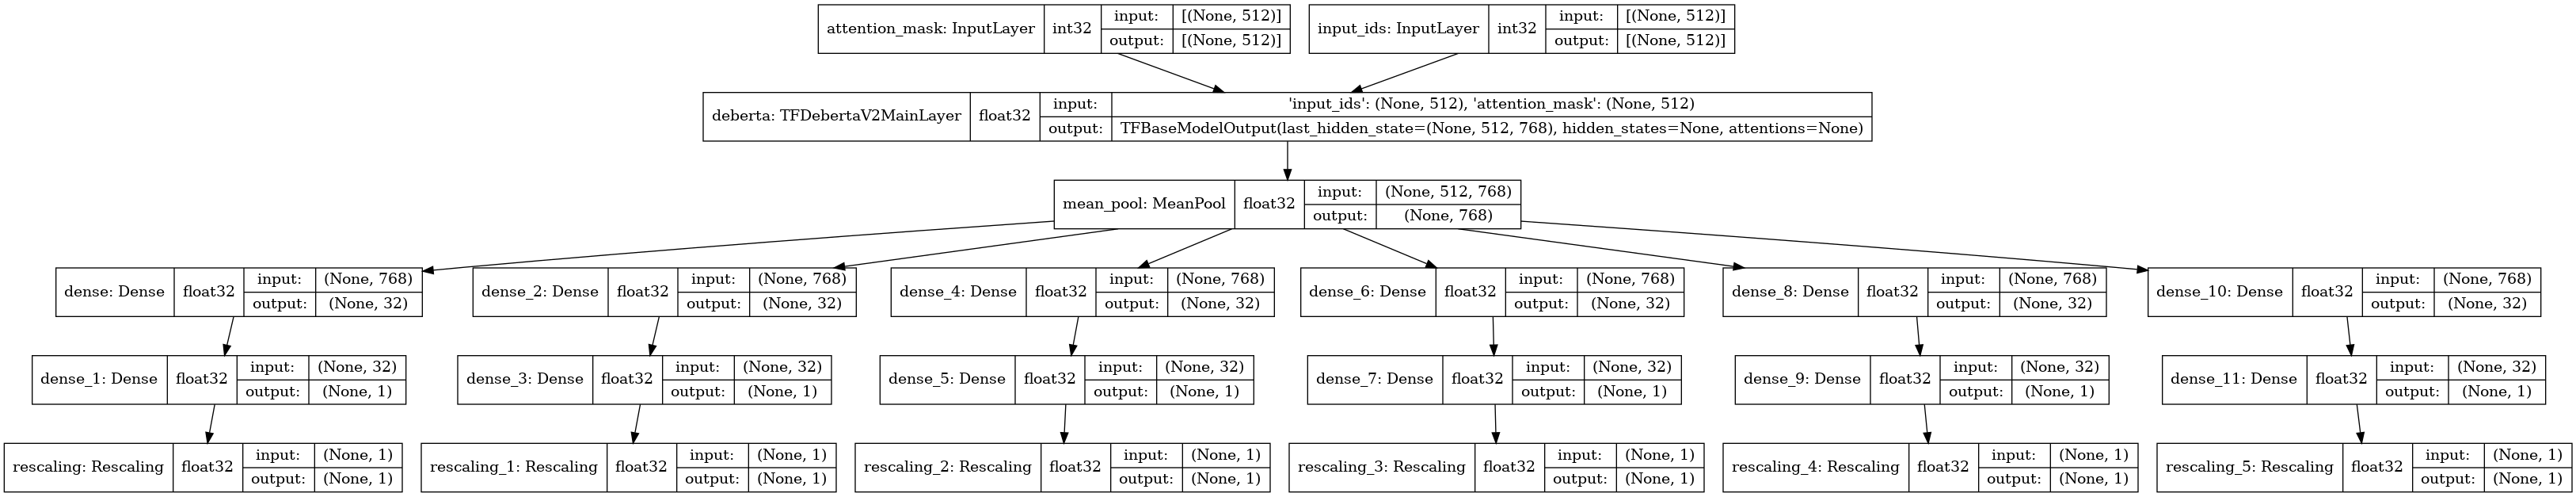

In [14]:
#Visualize Model Structure
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True)

In [15]:
#Model training
t1=datetime.datetime.now()
out = model.fit(train_dataset,validation_data=test_dataset,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,callbacks=[reduceLR,es],epochs=10,verbose=1)
print("#"*150)
print("Total time taken: ", datetime.datetime.now()-t1)

Epoch 1/10


2022-11-01 18:59:38.987236: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


391/391 [==============================] - 593s 1s/step - loss: 1.9794 - rescaling_loss: 0.3523 - rescaling_1_loss: 0.2986 - rescaling_2_loss: 0.2692 - rescaling_3_loss: 0.3435 - rescaling_4_loss: 0.3869 - rescaling_5_loss: 0.3290 - rescaling_mean_squared_error: 0.3523 - rescaling_1_mean_squared_error: 0.2986 - rescaling_2_mean_squared_error: 0.2692 - rescaling_3_mean_squared_error: 0.3435 - rescaling_4_mean_squared_error: 0.3869 - rescaling_5_mean_squared_error: 0.3290 - val_loss: 1.5423 - val_rescaling_loss: 0.3056 - val_rescaling_1_loss: 0.2413 - val_rescaling_2_loss: 0.2263 - val_rescaling_3_loss: 0.2605 - val_rescaling_4_loss: 0.2593 - val_rescaling_5_loss: 0.2493 - val_rescaling_mean_squared_error: 0.3056 - val_rescaling_1_mean_squared_error: 0.2413 - val_rescaling_2_mean_squared_error: 0.2263 - val_rescaling_3_mean_squared_error: 0.2605 - val_rescaling_4_mean_squared_error: 0.2593 - val_rescaling_5_mean_squared_error: 0.2493
Epoch 2/10
391/391 [==============================] - 

In [17]:
import matplotlib.pyplot as plt

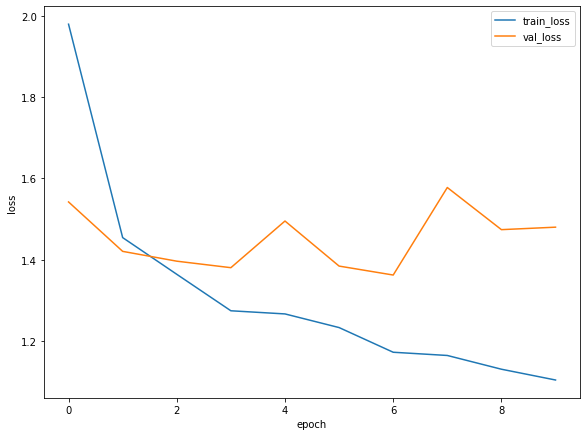

In [18]:
#Loss curve
plt.figure(figsize=(6.4*1.5,4.8*1.5)) 
plt.plot(out.history['loss'])
plt.plot(out.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

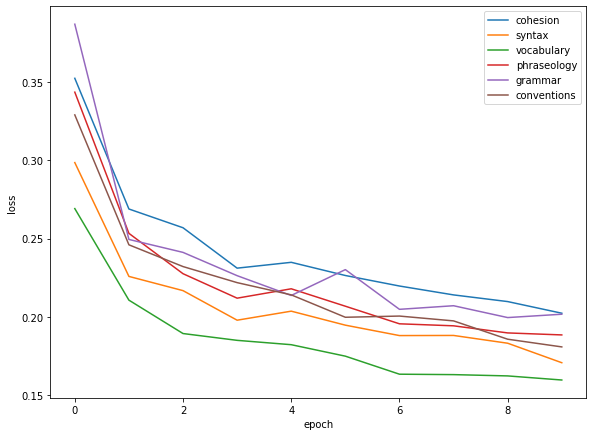

In [19]:
#Category wise training loss
plt.figure(figsize=(6.4*1.5,4.8*1.5)) 
plt.plot(out.history['rescaling_loss'])
plt.plot(out.history['rescaling_1_loss'])
plt.plot(out.history['rescaling_2_loss'])
plt.plot(out.history['rescaling_3_loss'])
plt.plot(out.history['rescaling_4_loss'])
plt.plot(out.history['rescaling_5_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"])
plt.show()

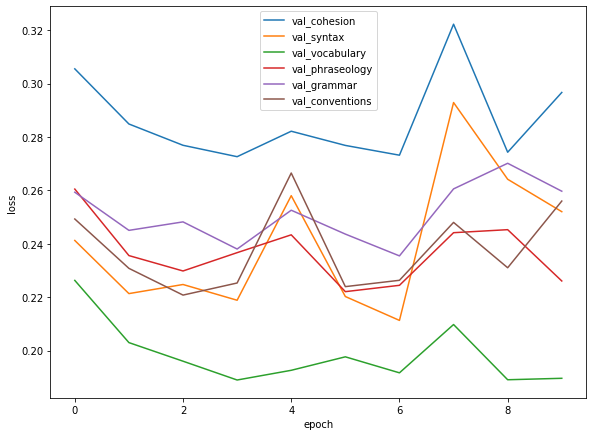

In [20]:
#Category wise validation loss
plt.figure(figsize=(6.4*1.5,4.8*1.5)) 
plt.plot(out.history['val_rescaling_loss'])
plt.plot(out.history['val_rescaling_1_loss'])
plt.plot(out.history['val_rescaling_2_loss'])
plt.plot(out.history['val_rescaling_3_loss'])
plt.plot(out.history['val_rescaling_4_loss'])
plt.plot(out.history['val_rescaling_5_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["val_cohesion", "val_syntax", "val_vocabulary", "val_phraseology", "val_grammar", "val_conventions"])
plt.show()

In [21]:
#Making prediction on test dataset
Y_pred = model.predict(test_dataset_wo_label)

In [22]:
_, Y1_test, Y2_test, Y3_test, Y4_test, Y5_test, Y6_test = inputfromDF(df_test)
Y_test = np.vstack([Y1_test, Y2_test, Y3_test, Y4_test, Y5_test, Y6_test]).T
Y_pred1 = np.vstack([roundoffScore(j) for j in i] for i in np.hstack([x for x in Y_pred]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
Y_pred1[0:20,:]

array([[3.5, 3. , 3. , 3. , 3. , 3.5],
       [4. , 3.5, 3.5, 3.5, 4. , 4. ],
       [2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
       [3.5, 3.5, 3.5, 4. , 3.5, 3.5],
       [4. , 4. , 3.5, 3.5, 4. , 4. ],
       [3.5, 3.5, 3.5, 3.5, 4. , 4. ],
       [3. , 3. , 3. , 2.5, 3. , 3. ],
       [4. , 4. , 4. , 4. , 4. , 4. ],
       [3. , 3. , 3. , 3. , 2.5, 3. ],
       [3.5, 3.5, 3.5, 3.5, 3.5, 3.5],
       [4. , 4. , 4. , 4. , 4. , 4. ],
       [3.5, 3. , 3.5, 3.5, 3. , 3.5],
       [2.5, 2.5, 2.5, 2.5, 2.5, 3.5],
       [3. , 3. , 3. , 3. , 3. , 3.5],
       [3.5, 3.5, 4. , 4. , 3.5, 4. ],
       [3.5, 3. , 3. , 3. , 3. , 3. ],
       [4. , 3.5, 3.5, 3.5, 4. , 3.5],
       [3.5, 3. , 3.5, 3. , 2.5, 3. ],
       [2. , 2. , 2.5, 2.5, 2. , 2. ],
       [3. , 3. , 3. , 3. , 2.5, 3. ]])

In [24]:
#Category wise RMSE for each target after prediction roundoff
MCRMSE(Y_test, Y_pred1)

MSE for cohesion : 0.3142
MSE for syntax : 0.2784
MSE for vocabulary : 0.2066
MSE for phraseology : 0.2474
MSE for grammar : 0.2848
MSE for conventions : 0.2826


0.26899744572158363

In [25]:
#Category wise RMSE for each target of prediction
print("MCRMSE without roundoff")
try:
    print(MCRMSE(Y_test, np.vstack([j for j in i] for i in np.hstack([x for x in Y_pred]))))
except:
    print("Error in MCRMSE")
    pass

MCRMSE without roundoff
MSE for cohesion : 0.2967
MSE for syntax : 0.2510
MSE for vocabulary : 0.1890
MSE for phraseology : 0.2266
MSE for grammar : 0.2614
MSE for conventions : 0.2555
0.24667526342026883


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


### Prediction on unseen data

In [26]:
Y_pred_sub = model.predict(sub_dataset)

In [27]:
Y_pred_sub1 = np.vstack([j for j in i] for i in np.hstack([x for x in Y_pred_sub]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [28]:
df_sub['cohesion'] = Y_pred_sub1[:,0]
df_sub['syntax'] = Y_pred_sub1[:,1]
df_sub['vocabulary']= Y_pred_sub1[:,2]
df_sub['phraseology']= Y_pred_sub1[:,3]
df_sub['grammar']= Y_pred_sub1[:,4]
df_sub['conventions']= Y_pred_sub1[:,5]

In [29]:
#Unseen data prediction
df_sub.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.071291,2.809591,3.162009,2.998096,2.817017,2.677121
1,000BAD50D026,Do you think students would benefit from being...,2.763062,2.328534,2.586216,2.359921,2.165203,2.554746
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.972683,3.611913,3.528498,3.663153,3.700022,3.613994


In [30]:
df_sub.drop(columns=['full_text']).to_csv("predictions.csv",index=False)